In [1]:
library(readxl)
library(timedeppar)

Loading required package: mvtnorm



# Import datasets

In [2]:
cols <- c("period", "delta_period", "amplitude", "delta_amplitude", 
          "phase", "delta_phase")

df_stal <- read_excel("./data/Borneo Stalagmite 02.04.25.xlsx", 
                  range="N11:S18", col_names=cols)

df_delta <- read_excel("./data/d18O NGRIP 21.04.24.xlsx", sheet="Spectra d18O", 
                  range="B11:G33", col_names=cols)

raw <- read_excel("./data/d18O NGRIP 21.04.24.xlsx", 
                       sheet="Raw Data", range="C11:D6124", 
                       col_names=c("Age", "d18O"))

df_stal <- df_stal[1:nrow(df_stal),]
df_delta <- df_delta[1:nrow(df_delta),]
raw <- raw[raw[,1] <= 30000,]
raw["d18O"] <- raw$d18O - mean(raw$d18O)

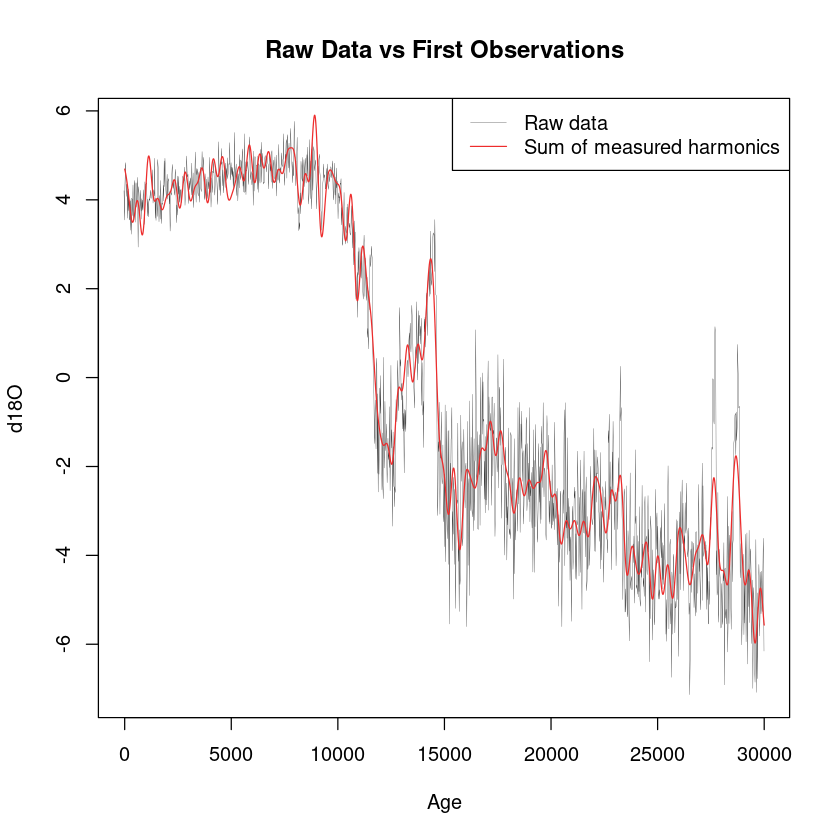

In [3]:
# sum of the harmonics for every parameter
t <- seq(1,30000,length.out=30000)
y <- numeric(30000)
for (i in 1:nrow(df_delta)) {
    row <- as.numeric(df_delta[i,])
    P <- row[1]
    A <- row[3]
    phi <- row[5]
    y <- y + A*cos(2*pi*t/P + phi)
}

plot(raw, type = "l", lwd = 0.2,
     main = "Raw Data vs First Observations",
     xlab = "Age", ylab = "d18O"
)
lines(t, y, col = "firebrick2")
legend("topright", lty = c(1,1), 
       col = c("black", "firebrick2"), lwd = c(0.2,1),
       legend=c("Raw data","Sum of measured harmonics"))

# Identify reference periods

In [4]:
ref_delta_idx <- c()
ref_stal_idx <- c()

cat("Reference periods:\n(d18O), (stal.), (rel. diff.)\n")
for (i in 1:nrow(df_delta)) {
    for (j in 1:nrow(df_stal)) {
        period_delta <- df_delta$period[i]
        period_stal <- df_stal$period[j]
        period_mean <- mean(period_delta, period_stal)
        
        # calculate relative difference and check if acceptable
        rel_diff <- abs(period_delta - period_stal) / period_mean
        if (rel_diff <= 0.04) {            
            ref_delta_idx <- c(ref_delta_idx, i)
            ref_stal_idx <- c(ref_stal_idx, j)
            
            cat(period_delta,",",period_stal,",",rel_diff,"\n")
        }
    }
}

Reference periods:
(d18O), (stal.), (rel. diff.)
2923.2 , 3025.4 , 0.03496169 
2556.7 , 2626.2 , 0.02718348 


# Initialize parameters

In [5]:
sigma_y <- 0.2
xi_gamma <- 10

In [6]:
# Initial values
param.ini <- list(
    sigma_y = sigma_y
)

# Ranges
param.range <- list(
    sigma_y = c(0.01, 10),
    xi_sd = c(0.01, 10),
    xi_gamma = c(1, 20)
)

# Log-scale inference
param.log <- c(sigma_y=TRUE, xi=TRUE)


# harmonics
free_idx <- setdiff(1:nrow(df_delta), ref_delta_idx)
for (i in free_idx) {
    name <- paste0("Period", i)
    Period <- df_delta$period[i]
    dPeriod <- df_delta$delta_period[i]
    
    param.ini[[name]] <- Period
    # param.range[[name]] <- c(Period - dPeriod, Period + dPeriod)
    param.range[[name]] <- Period * c(0.97, 1.03)
    param.log[[name]] <- FALSE
}
for (i in 1:nrow(df_delta)) {
    A_name <- paste0("A", i)
    A <- df_delta$amplitude[i]
    dA <- df_delta$delta_amplitude[i]
    param.ini[[A_name]] <- A
    param.range[[A_name]] <- c(A - dA, A + dA)
    # param.range[[A_name]] <- A * c(0.97, 1.03)
    param.log[[A_name]] <- FALSE
    
    Phi_name <- paste0("Phi", i)
    Phi <- df_delta$phase[i]
    dPhi <- df_delta$delta_phase[i]
    param.ini[[Phi_name]] <- Phi
    # param.range[[Phi_name]] <- c(Phi - dPhi, Phi + dPhi)
    # param.range[[Phi_name]] <- Phi * c(0.97, 1.03)
    param.range[[Phi_name]] <- c(0, 2*pi)
    param.log[[Phi_name]] <- FALSE
}

# OU process
times <- raw$Age[-nrow(raw)]
time_diff <- diff(times)
xi_mean <- mean(time_diff)
xi_sd <- sd(time_diff)

param.ini$xi <- randOU(
    mean = xi_mean,
    sd = xi_sd,
    gamma = xi_gamma,
    t = times
)
param.range$xi_mean <- c(xi_mean - xi_sd, xi_mean + xi_sd)
param.ou.ini <- c(
    xi_mean = xi_mean,
    xi_sd = xi_sd,
    xi_gamma = xi_gamma
)

# Logprior
omega0   <- 2*pi/df_delta$period[free_idx]
omega_sd <- 0.01 * omega0
param.logprior <- function(th){
  sum(dnorm(th[paste0("Period",free_idx)],
            mean = omega0,
            sd   = omega_sd,
            log  = TRUE))
}

# Log likelihood

In [7]:
loglikeli <- function(params, data) {
    # build time series from intervals
    xi <- params$xi[,2]
    t <- c(data$Age[1], data$Age[1] + cumsum(xi))
    
    y_hat <- numeric(length(t))
    
    # free harmonics
    for (i in free_idx) {
        A <- params[[paste0("A", i)]]
        Phi <- params[[paste0("Phi", i)]]
        Omega <- 2 * pi / params[[paste0("Period", i)]]
        
        y_hat <- y_hat + A * cos(Omega * t + Phi)
    }
    
    # locked harmonics
    for (i in 1:length(ref_delta_idx)) {
        j <- ref_delta_idx[i]
        A <- params[[paste0("A", j)]]
        Phi <- params[[paste0("Phi", j)]]
        Omega <- 2 * pi / df_stal$period[ ref_stal_idx[i] ]
        
        y_hat <- y_hat + A * cos(Omega * t + Phi)
    }
    
    # feedback
    count <<- count + 1
    current_percent <- as.integer(100 * count / max_count)
    if (current_percent > percent) {
        percent <<- current_percent
        # draw percent bar
        filled <- floor(percent / 2)
        bar <- c(
            rep("=", filled),
            ">",
            rep(" ", 50 - filled - 1),
            "]"
        )
        # bar <- paste(rep("=", percent), collapse="")
        #cat("\r[", bar, ">", "]\t", percent, "%", sep="")
        cat(paste0("\r[", paste(bar, collapse = ""), "  ", current_percent, "%"))
        
        flush.console()
    }
    
    # log-likelihood of observed data
    return( sum(dnorm(data$d18O, mean = y_hat, 
                      sd = params$sigma_y, log=TRUE)) )
}

# Run inference

In [8]:
n_iter <- 100
n_interval <- 25
max_count <- n_iter * (n_interval + 1)

infer.timedeppar (timedeppar 1.0.3 2023-08-28): starting new Markov Chain

  number of constant parameters:          68

  number of time-dependent parameters:    1

  number of estimated process parameters: 3



[=================================================>]  99%

100 iterations completed

  acceptance frequency of constant parameters:             0.267

  acceptance frequencies of time-dependent parameters:     0.362

  acceptance frequencies of Ornstein-Uhlenbeck parameters: 0.0167

plot.timedeppar (timedeppar 1.0.3 2023-08-28): plotting inference results: traces,time-series



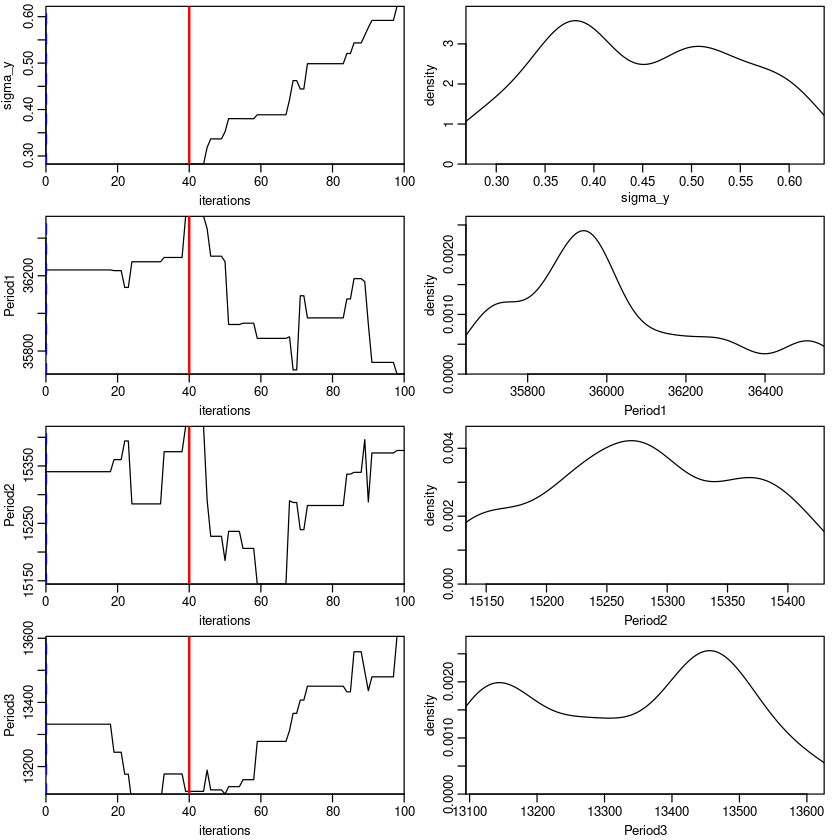

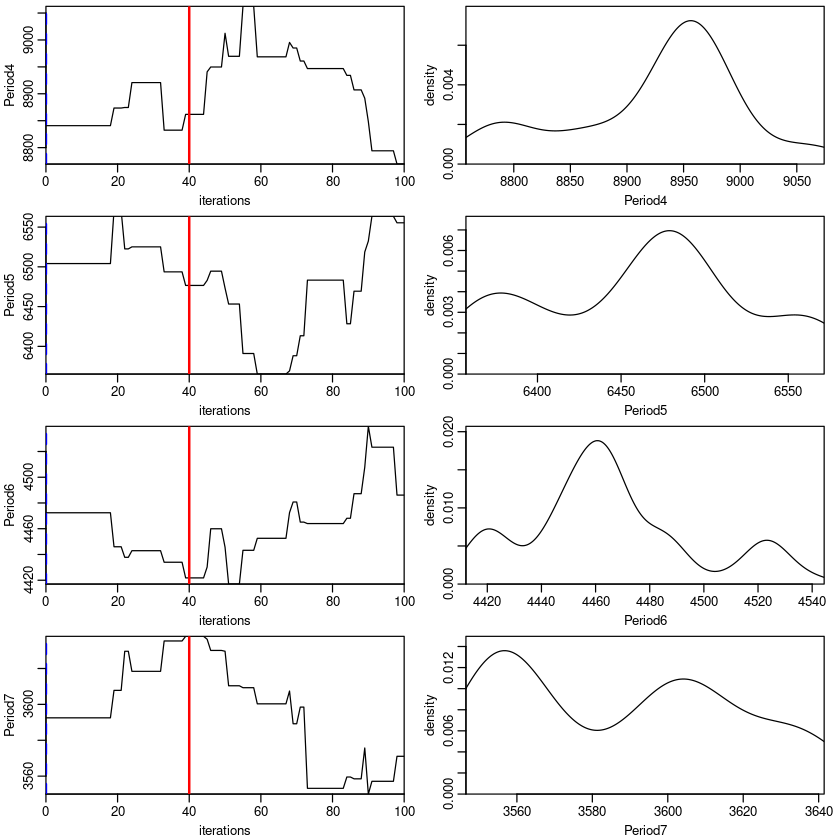

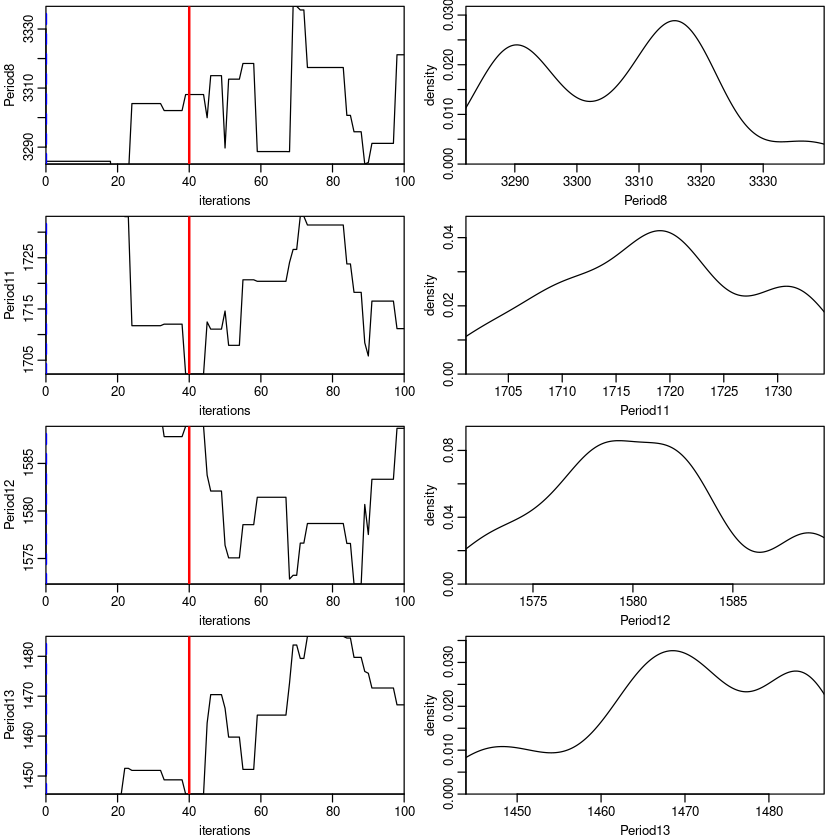

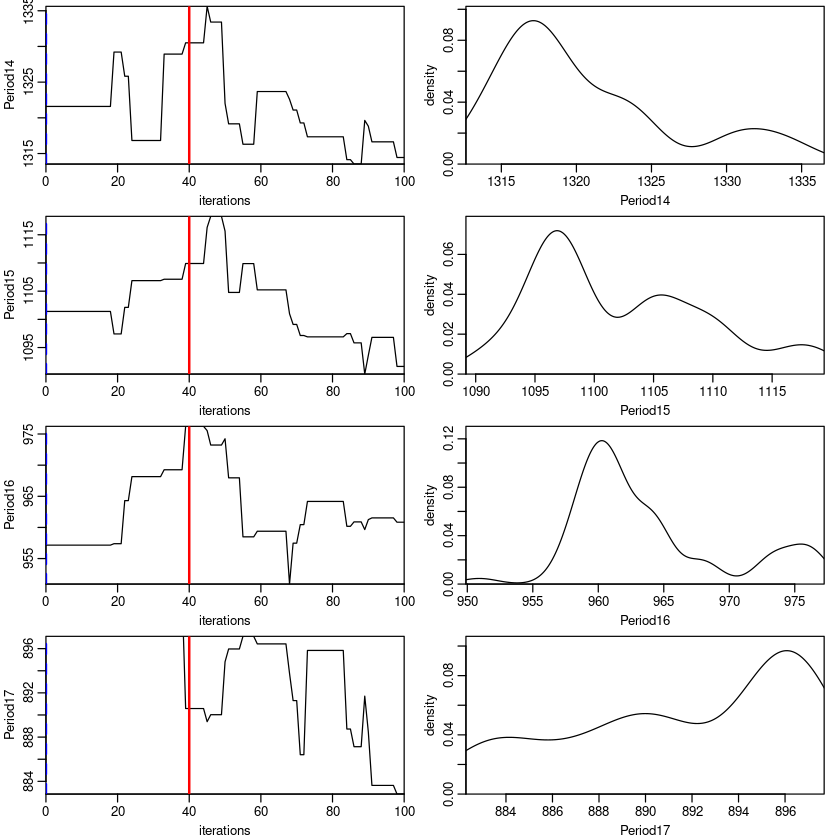

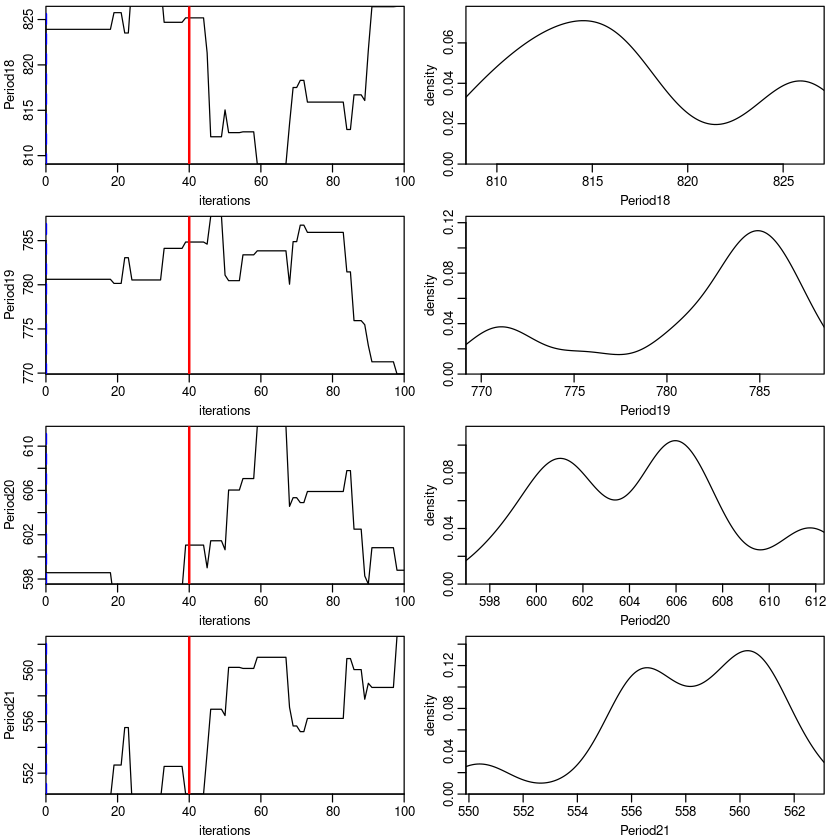

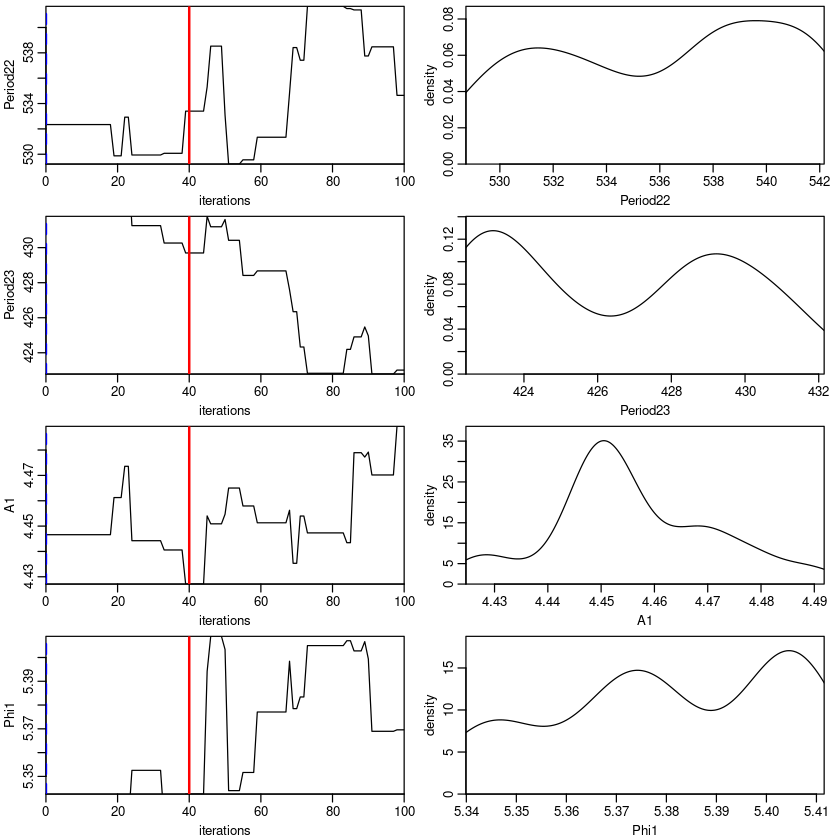

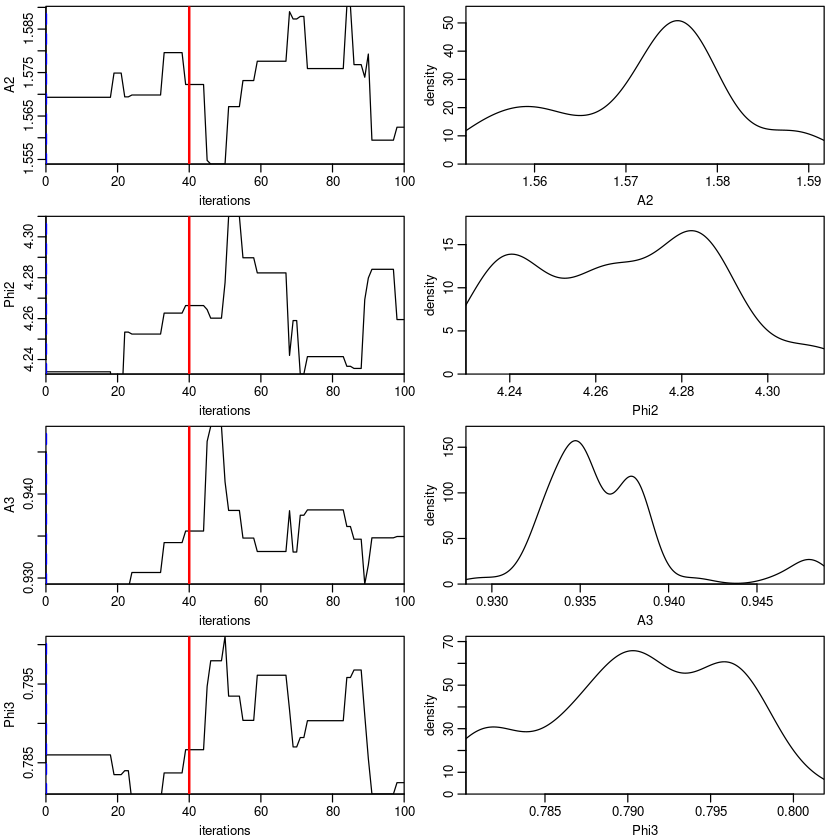

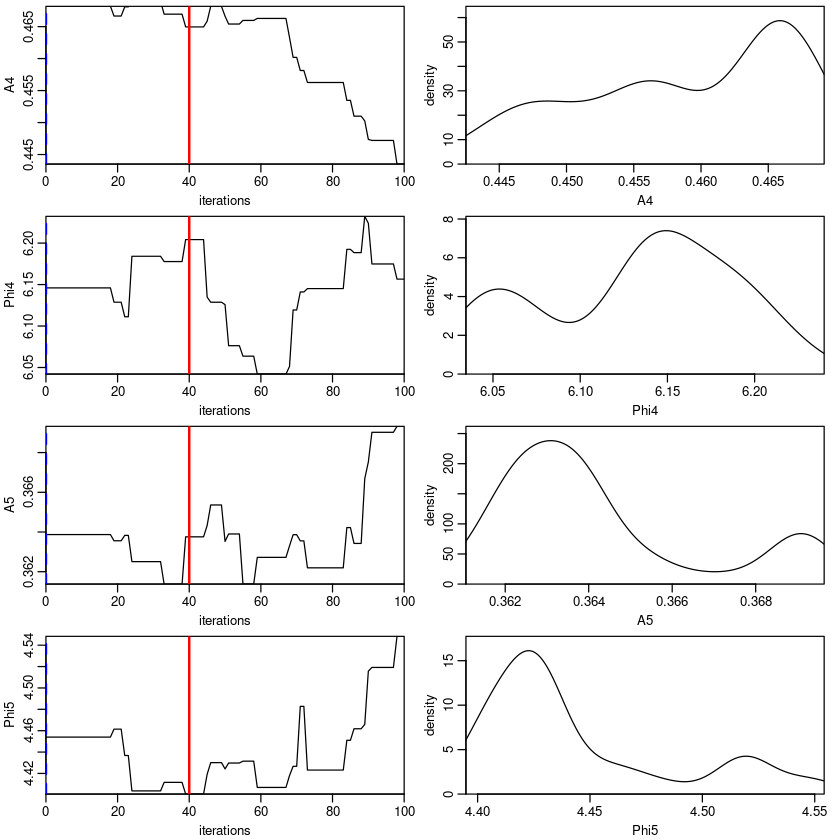

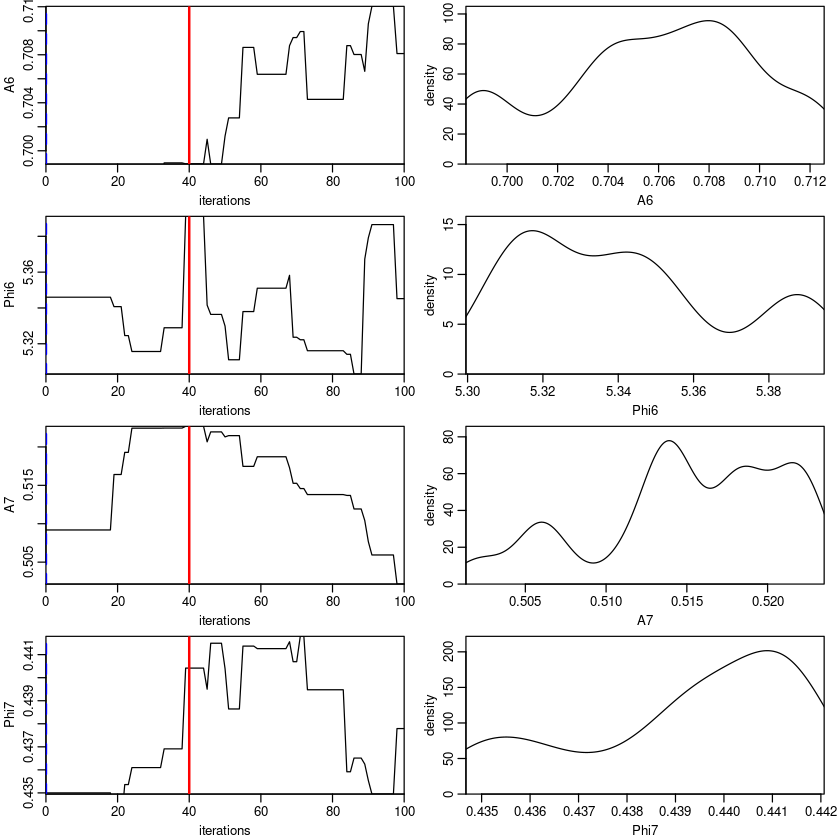

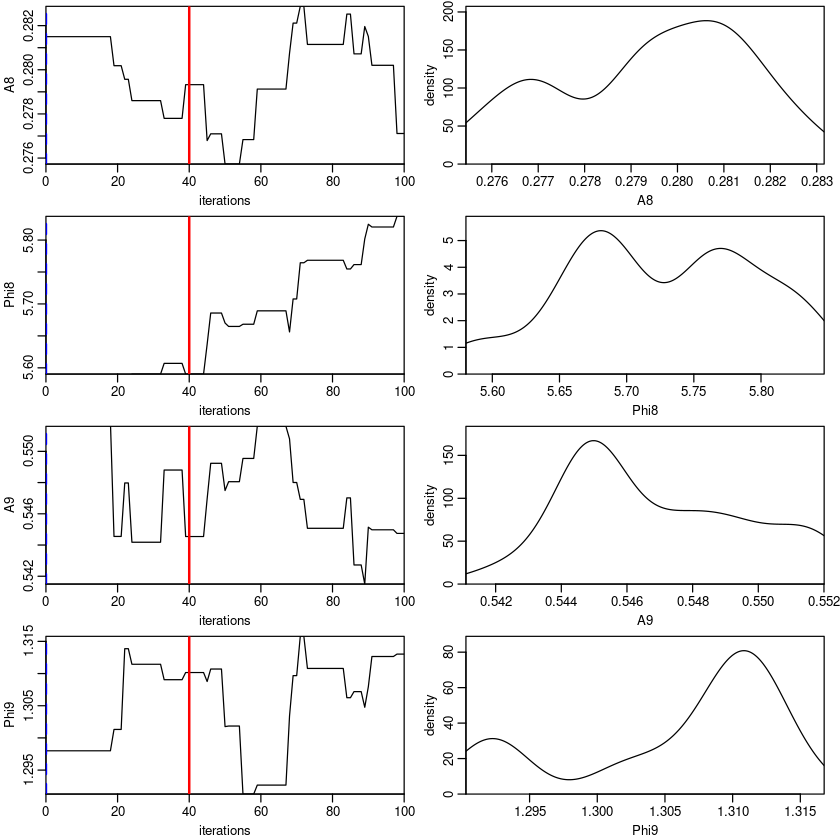

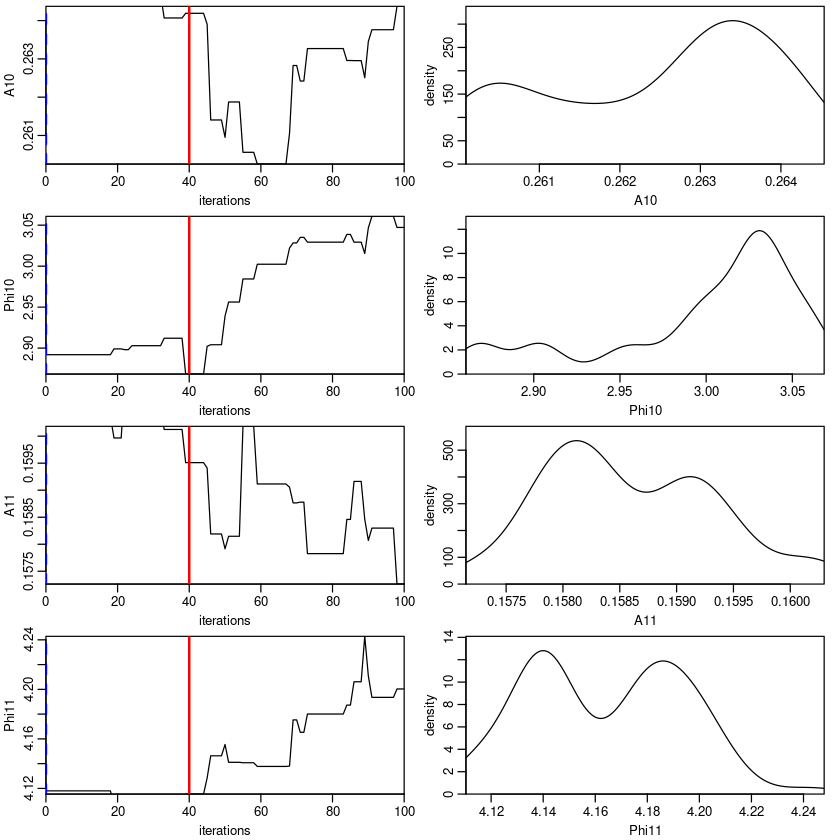

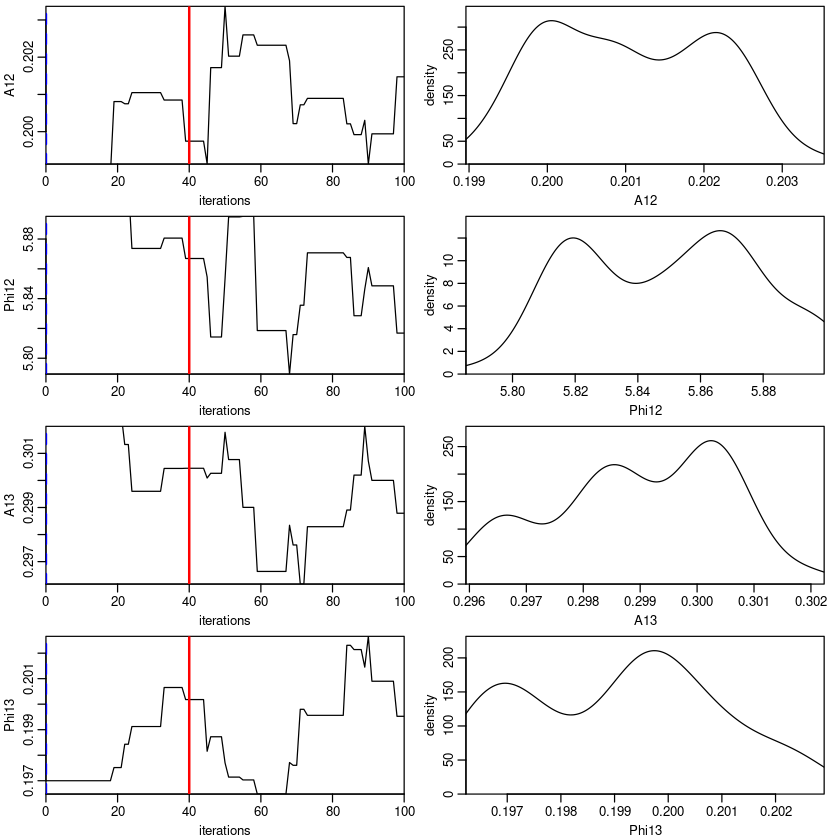

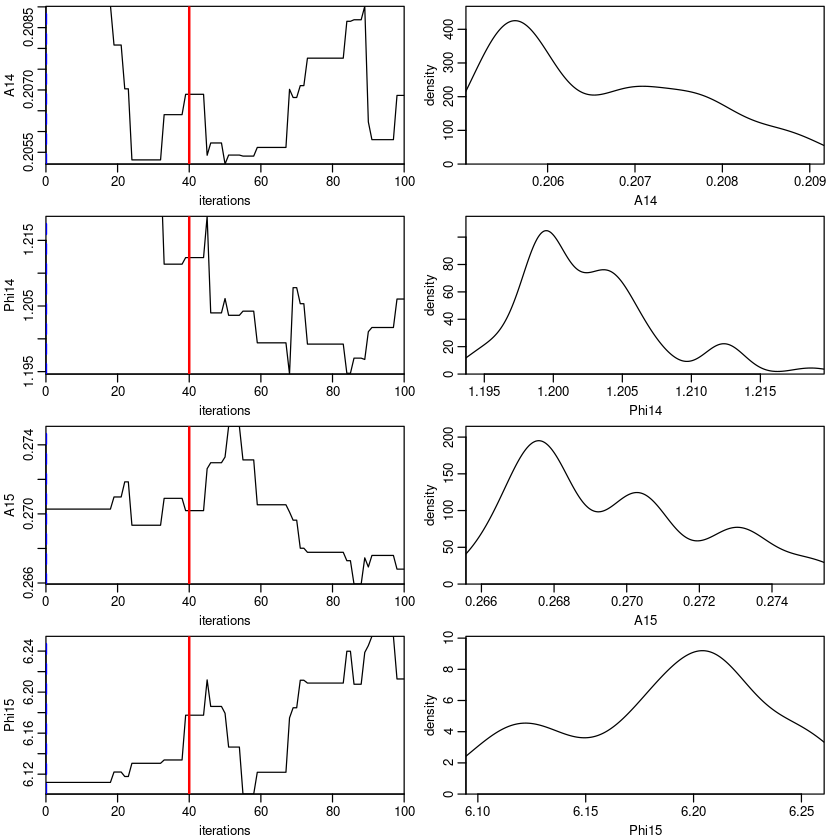

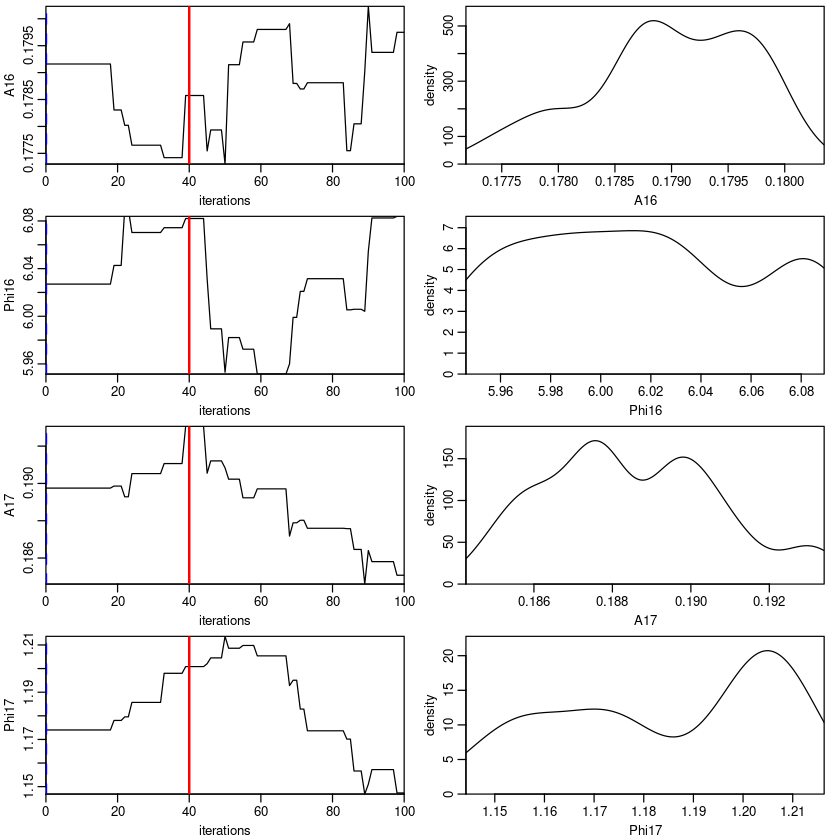

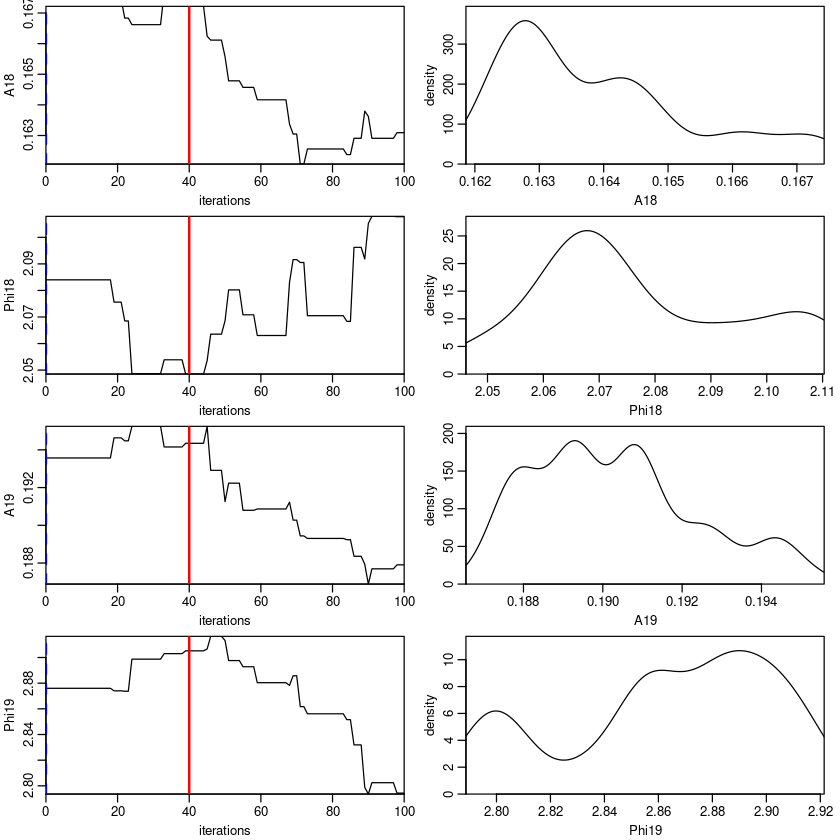

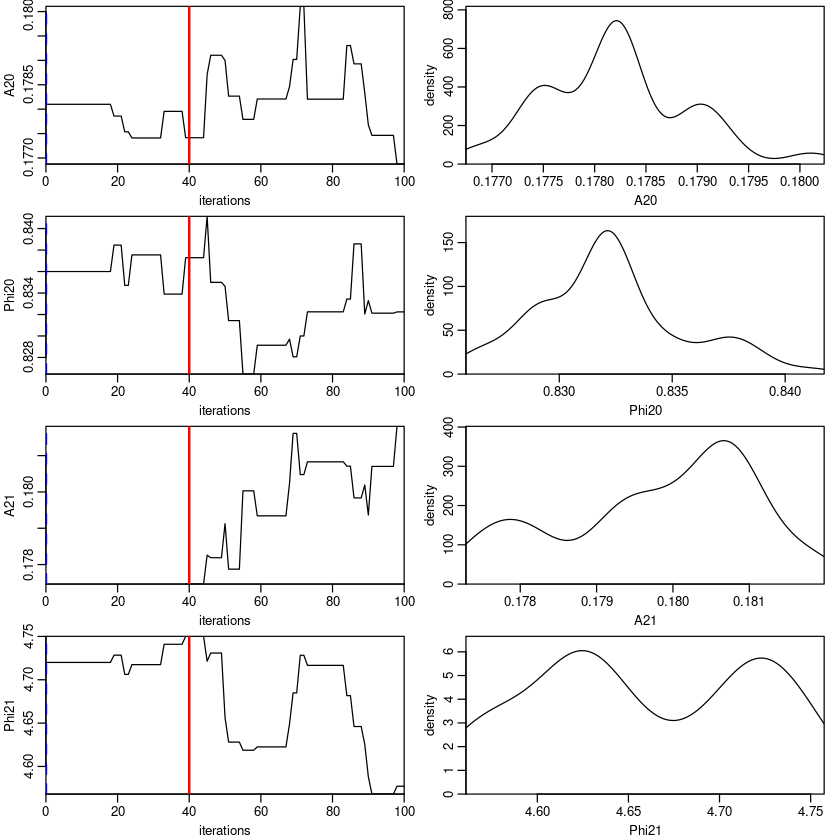

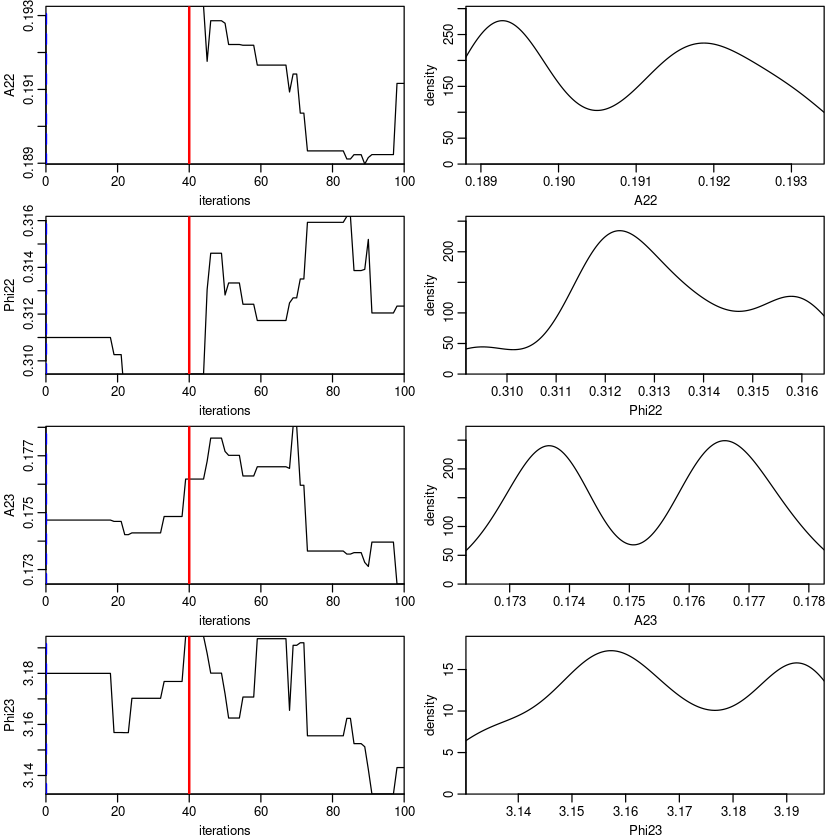

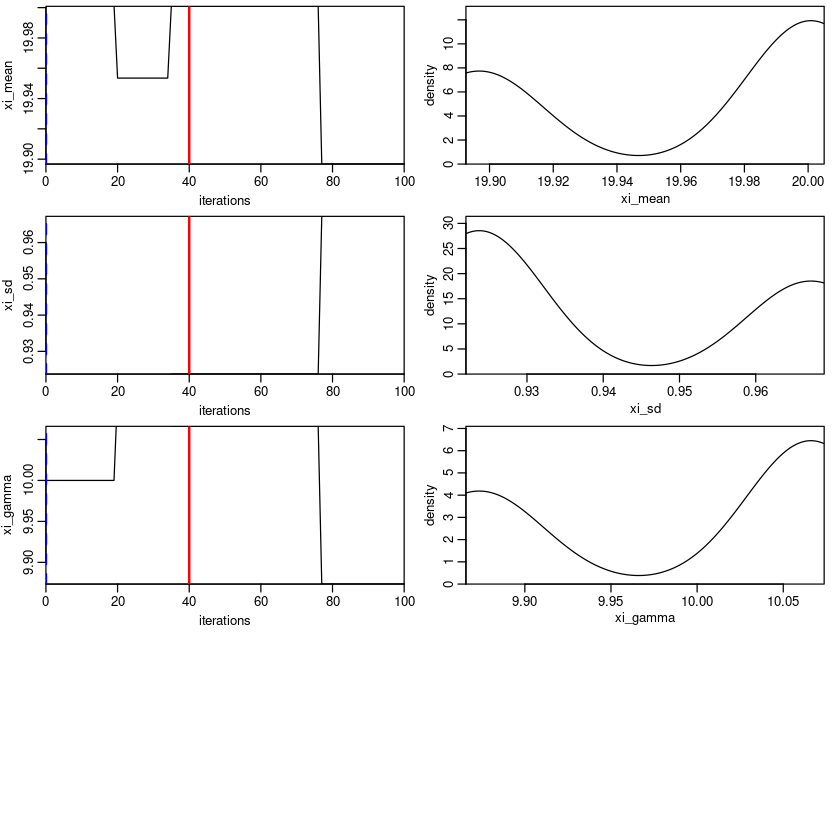

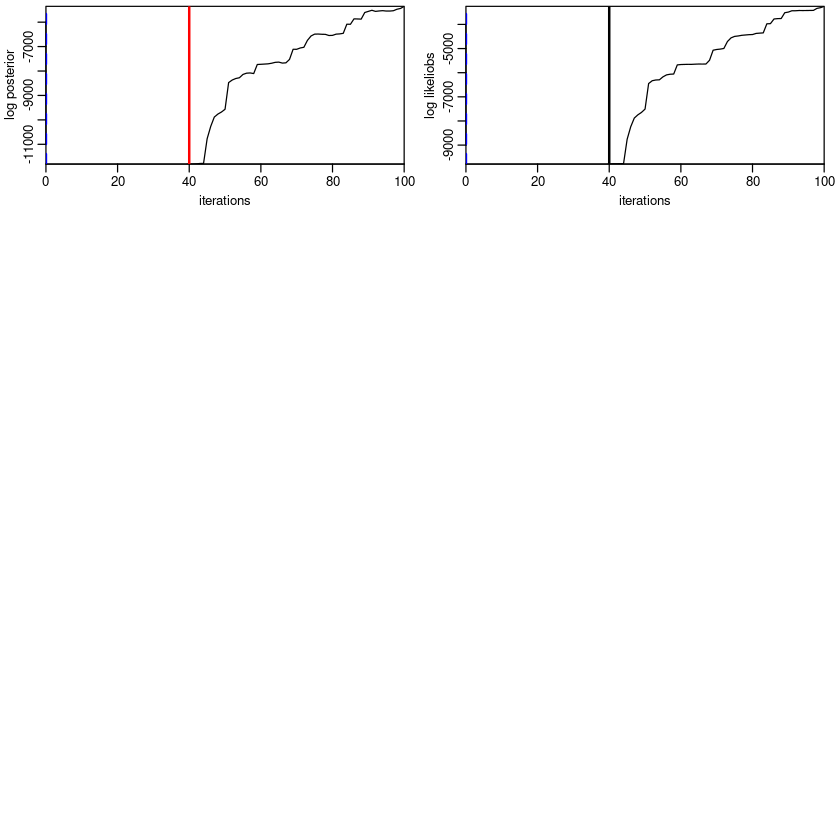

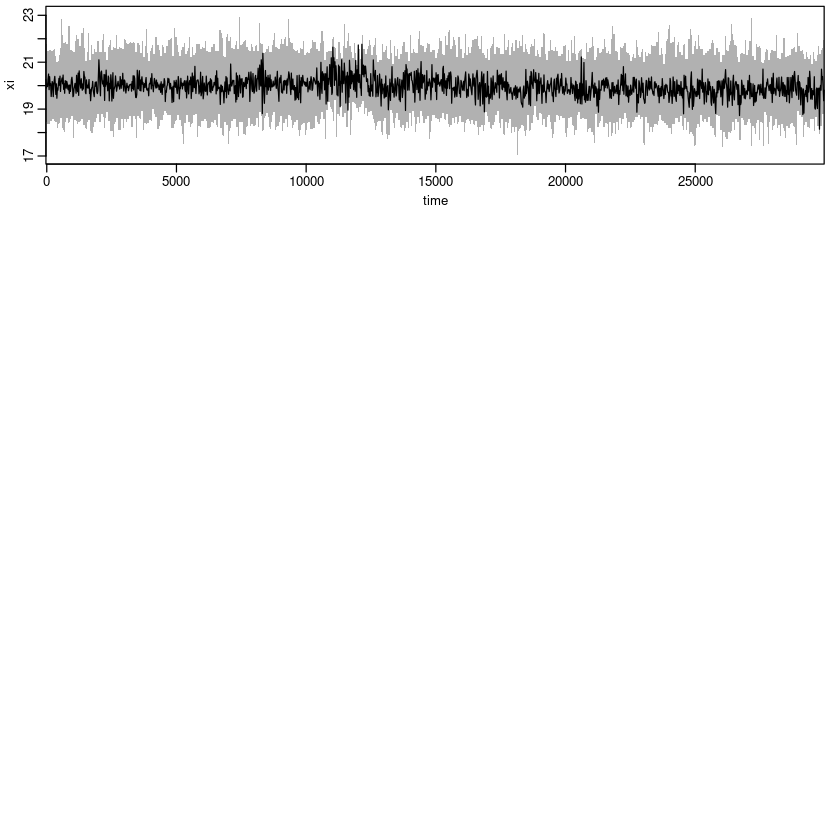

In [9]:
count <- 0
percent <- 0

res <- infer.timedeppar(
    loglikeli = loglikeli,
    data = raw,
    param.ini = param.ini,
    param.range = param.range,
    param.ou.ini = param.ou.ini,
    param.log = param.log,
    n.iter = n_iter,
    control = list(
        n.interval = n_interval,
        n.adapt = floor(0.4 * n_iter)
    ),
    verbose = 0
)
plot(res, type = c("traces","time-series"));

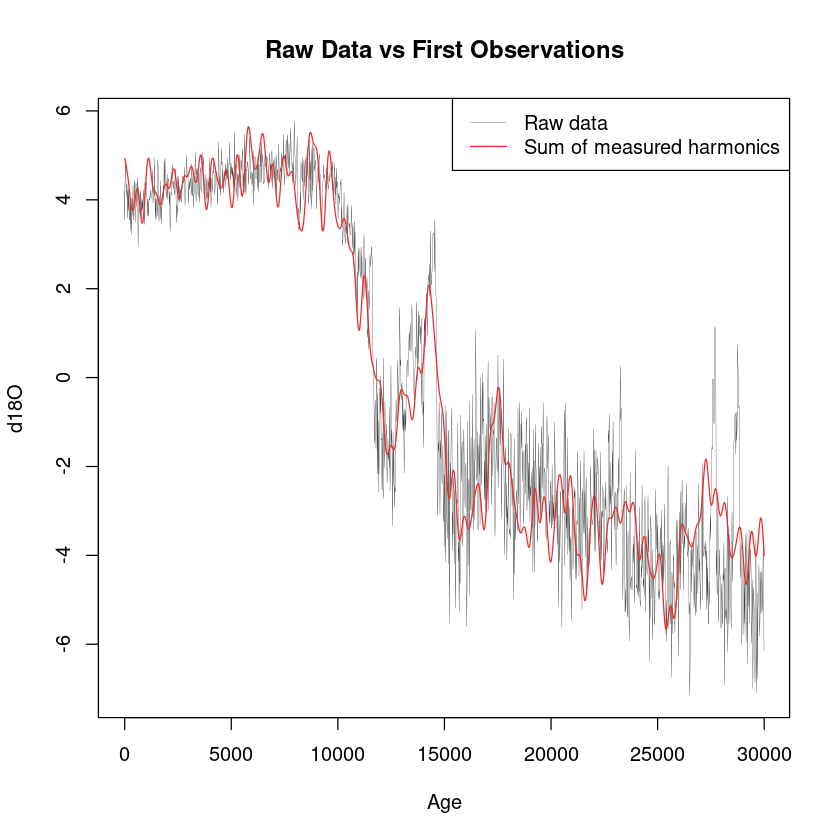

In [14]:
predict <- function(params) {
    # build time series from intervals
    xi <- params$xi[,2]
    # t <- c(data$Age[1], data$Age[1] + cumsum(xi))
    t <- 1:30000
    
    y_hat <- numeric(length(t))
    # free harmonics
    for (i in free_idx) {
        A <- params[[paste0("A", i)]]
        Phi <- params[[paste0("Phi", i)]]
        Omega <- 2 * pi / params[[paste0("Period", i)]]
        
        y_hat <- y_hat + A * cos(Omega * t + Phi)
    }
    
    # locked harmonics
    for (i in 1:length(ref_delta_idx)) {
        j <- ref_delta_idx[i]
        A <- params[[paste0("A", j)]]
        Phi <- params[[paste0("Phi", j)]]
        Omega <- 2 * pi / df_stal$period[ ref_stal_idx[i] ]
        
        y_hat <- y_hat + A * cos(Omega * t + Phi)
    }
    
    plot(raw, type = "l", lwd = 0.2,
        main = "Raw Data vs First Observations",
        xlab = "Age", ylab = "d18O"
    )
    lines(t, y_hat, col = "firebrick2")
    legend("topright", lty = c(1,1), 
           col = c("black", "firebrick2"), lwd = c(0.2,1), 
           legend=c("Raw data","Sum of measured harmonics"))
}

predict(res$param.maxpost)